## **Data Understanding**

### 1. Deskripsi Dataset

Dataset ini berfokus pada **diagnosis akut limfoblastik leukemia (ALL)** melalui analisis **citra *Peripheral Blood Smear (PBS)***. ALL merupakan salah satu kanker yang cukup umum, di mana diagnosis biasanya membutuhkan tes invasif, mahal, dan memakan waktu.
Penggunaan citra PBS menjadi langkah penting dalam **skrining awal kanker** karena lebih cepat dan non-invasif, meskipun masih rawan kesalahan diagnosis akibat tanda dan gejala ALL yang tidak spesifik.

Dataset ini dibuat oleh **Laboratorium Sumsum Tulang Rumah Sakit Taleqani (Tehran, Iran)** dengan karakteristik sebagai berikut:

* **Jumlah citra**: 3.256 gambar PBS.
* **Jumlah pasien**: 89 pasien yang dicurigai ALL.
* **Format citra**: JPG.
* **Perbesaran mikroskop**: 100x menggunakan kamera Zeiss.
* **Penentuan label**: Dilakukan oleh spesialis menggunakan **flow cytometry tool**.

---

### 2. Kelas Data

Dataset terbagi menjadi **dua kelas utama**:

1. **Benign (Non-Kanker)**

   * Terdiri dari *hematogones* (sel normal).

2. **Malignant (Kanker - ALL)**

   * Dikelompokkan lagi ke dalam **tiga subtipe limfoblas ganas**, yaitu:

     * **Early Pre-B ALL**
     * **Pre-B ALL**
     * **Pro-B ALL**

---

### 3. Proses Pengolahan Data Awal

* **Pewarnaan sampel** dilakukan oleh staf laboratorium berpengalaman.
* **Segmentasi citra** dilakukan dengan **thresholding berbasis warna** pada ruang warna HSV.
* Dataset menyediakan **citra asli** serta **citra hasil segmentasi**.

---

### 4. Tujuan Dataset

Dataset ini dirancang untuk:

* Mendukung penelitian dalam **klasifikasi ALL dan subtipenya**.
* Menjadi benchmark untuk pengembangan **model CNN (Convolutional Neural Network)** yang efisien dan cepat.
* Membantu meningkatkan akurasi skrining awal kanker hematologi berbasis citra.

---

### 5. Referensi

* 📄 **Paper**: *A Fast and Efficient CNN Model for B-ALL Diagnosis and its Subtypes Classification using Peripheral Blood Smear Images*
* 💻 **Source Code**: [GitHub Repository](https://github.com/MehradAria/ALL-Subtype-Classification)

## **Data Preparation**

In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import itertools
from pathlib import Path

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.metrics import classification_report, confusion_matrix

import warnings
warnings.filterwarnings("ignore")
tf.get_logger().setLevel('ERROR')

In [2]:
TRAIN_DATA_DIR = "data/Final/train"
TEST_DATA_DIR = "data/Final/test"
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 2025
EPOCHS = 30
MODEL_SAVE_PATH = "model/cnn_all_model.h5"

In [3]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
TRAIN_DATA_DIR,
seed=SEED,
image_size=IMG_SIZE,
batch_size=BATCH_SIZE,
label_mode='int'
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
TEST_DATA_DIR,
seed=SEED,
image_size=IMG_SIZE,
batch_size=BATCH_SIZE,
label_mode='int'
)

Found 12000 files belonging to 4 classes.
Found 979 files belonging to 4 classes.


In [4]:
class_names = train_ds.class_names
num_classes = len(class_names)
print("Classes:", class_names)

Classes: ['Benign', 'Early', 'Pre', 'Pro']


In [5]:
# Optimize dataset performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

## **Modelling**

In [6]:
# Build the CNN model
def cnn_model(input_shape=(*IMG_SIZE, 3), num_classes=num_classes):

    inputs = keras.Input(shape=input_shape)
    x = layers.Rescaling(1./255)(inputs)

    x = layers.Conv2D(32, 3, activation='relu', padding='same')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(128, 3, activation='relu', padding='same')(x)
    x = layers.MaxPooling2D()(x)


    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(256, activation='swish')(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = keras.Model(inputs, outputs, name='CNN_ALL_Classifier')
    return model

model = cnn_model()
model.summary()

Model: "CNN_ALL_Classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                            

In [7]:
# Compile
model.compile(
optimizer=keras.optimizers.Adam(),
loss='sparse_categorical_crossentropy',
metrics=['accuracy']
)

In [8]:
callbacks = [
keras.callbacks.ModelCheckpoint(MODEL_SAVE_PATH, save_best_only=True, monitor='val_loss'),
keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1618, patience=1, verbose=1),
keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)
]

In [9]:
history = model.fit(
train_ds,
validation_data=val_ds,
epochs=EPOCHS,
callbacks=callbacks
)

Epoch 1/30
375/375 [==============================] - 26s 64ms/step - loss: 0.8196 - accuracy: 0.6290 - val_loss: 0.5241 - val_accuracy: 0.7722 - lr: 0.0010
Epoch 2/30
375/375 [==============================] - 20s 54ms/step - loss: 0.4092 - accuracy: 0.8363 - val_loss: 0.4241 - val_accuracy: 0.7998 - lr: 0.0010
Epoch 3/30
375/375 [==============================] - 20s 54ms/step - loss: 0.3108 - accuracy: 0.8792 - val_loss: 0.2295 - val_accuracy: 0.9060 - lr: 0.0010
Epoch 4/30
375/375 [==============================] - ETA: 0s - loss: 0.2676 - accuracy: 0.8946
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00016180000768508762.
375/375 [==============================] - 20s 54ms/step - loss: 0.2676 - accuracy: 0.8946 - val_loss: 0.2302 - val_accuracy: 0.9183 - lr: 0.0010
Epoch 5/30
375/375 [==============================] - 20s 54ms/step - loss: 0.1996 - accuracy: 0.9248 - val_loss: 0.1890 - val_accuracy: 0.9305 - lr: 1.6180e-04
Epoch 6/30
375/375 [=============================

## **Evaluation**

In [13]:
# Load best model
if os.path.exists(MODEL_SAVE_PATH):
    model = keras.models.load_model(MODEL_SAVE_PATH)

In [14]:
# Build arrays of true labels and predictions for validation set
y_true = []
y_pred = []

# iterate over val_ds batches
for batch_images, batch_labels in val_ds:
    preds = model.predict(batch_images)
    preds_labels = np.argmax(preds, axis=1)
    y_true.extend(batch_labels.numpy().tolist())
    y_pred.extend(preds_labels.tolist())

1/1 [==============================] - 0s 135ms/step


In [15]:
# Classification report
report = classification_report(y_true, y_pred, target_names=class_names, digits=4)
print("\nClassification Report:\n", report)


Classification Report:
               precision    recall  f1-score   support

      Benign     0.8571    0.6667    0.7500        90
       Early     0.8866    0.9679    0.9254       218
         Pre     0.9718    0.9451    0.9582       182
         Pro     0.9699    1.0000    0.9847       161

    accuracy                         0.9278       651
   macro avg     0.9213    0.8949    0.9046       651
weighted avg     0.9269    0.9278    0.9250       651



In [16]:
# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

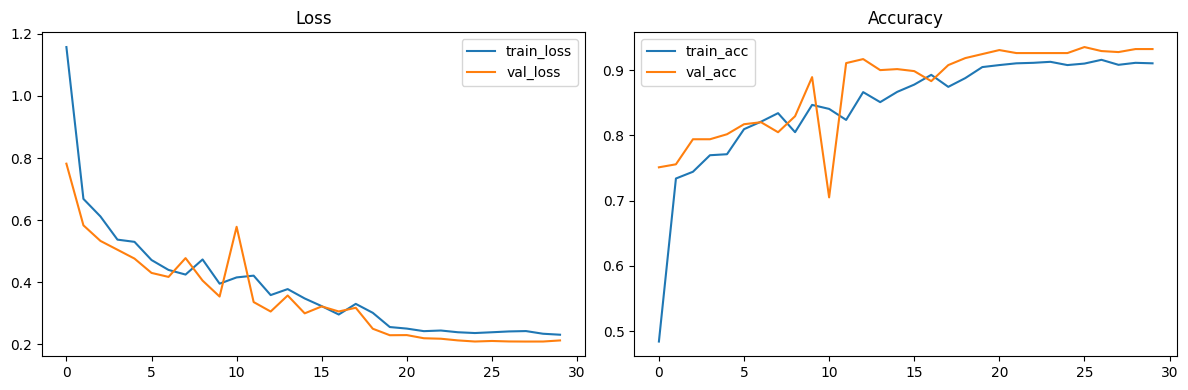

In [17]:
# Plot training history
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Loss')
plt.legend()


plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.title('Accuracy')
plt.legend()


plt.tight_layout()
plt.show()

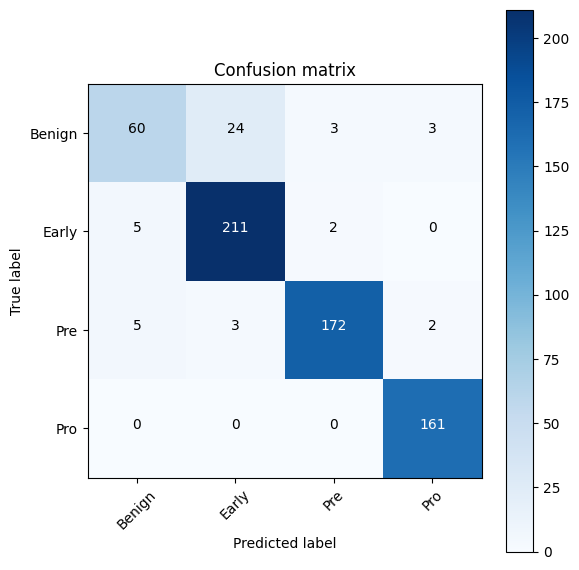

In [18]:
# Plot confusion matrix function
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix'):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    plt.figure(figsize=(6,6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)


    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], '.2f') if normalize else int(cm[i,j]),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")


    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


plot_confusion_matrix(cm, class_names, normalize=False, title='Confusion matrix')
plt.show()